# **Index**

1. [Introduction](#Introduction)
2. [Library Imports](#Library-Imports)
3. [Data Loading](#Data-Loading)
4. [Exploratory Data Analysis](#Exploratory-Data-Analysis)
   - [Univariate Analysis](#Univariate-Analysis)
5. [Data Preprocessing](#Data-Preprocessing)
6. [Feature Engineering](#Feature-Engineering)
7. [Modeling](#Modeling)
   - [Logistic Regression](#Logistic-Regression)
   - [Stochastic Gradient Descent (SGD) Classifier](#SGD-Classifier)
   - [Decision Tree Classifier](#Decision-Tree-Classifier)
   - [Random Forest Classifier](#Random-Forest-Classifier)
   - [Gradient Boosting Classifier](#Gradient-Boosting-Classifier)
   - [XGBoost Classifier](#XG-Boost-Classifier)
8. [Model Evaluation](#Model-Evaluation)
9. [Final Prediction and Conclusion](#Final-Prediction-and-Conclusion)


# **Introduction**

This project aims to predict the outcome of bank telemarketing efforts. This is a binary classification problem where target to predict takes 'Yes' or 'No' values.

The given dataset contains various attributes related to customers and their responses to marketing campaigns. By leveraging machine learning techniques, we seek to identify patterns and factors that influence customer responses to telemarketing calls. Understanding these dynamics will enable the bank to optimize its marketing strategies more efficiently.

In the following sections, we will explore the dataset, perform data preprocessing, and apply various machine learning models to ascertain the best predictors of success in bank telemarketing.

# **Library Imports**

In [1]:
# For Data Manipulation and mathematical functions
import numpy as np
import pandas as pd
import math
from scipy.stats import skew

# For Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Base classes for custom transformers
from sklearn.base import BaseEstimator, TransformerMixin

# Preprocessing
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder,StandardScaler, LabelEncoder, PowerTransformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer

# Feature Selection
from sklearn.feature_selection import SelectFromModel, RFE

# Model Selection and Evaluation
from sklearn.model_selection import train_test_split,GridSearchCV, RandomizedSearchCV
from sklearn.metrics import f1_score, make_scorer, ConfusionMatrixDisplay, confusion_matrix

# Machine Learning Models
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings("ignore")

# **Data Loading**

In [2]:
# Getting file paths under input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/predict-the-success-of-bank-telemarketing/sample_submission.csv
/kaggle/input/predict-the-success-of-bank-telemarketing/train.csv
/kaggle/input/predict-the-success-of-bank-telemarketing/test.csv


In [3]:
train = pd.read_csv('/kaggle/input/predict-the-success-of-bank-telemarketing/train.csv')
X_test = pd.read_csv('/kaggle/input/predict-the-success-of-bank-telemarketing/test.csv')
sample = pd.read_csv('/kaggle/input/predict-the-success-of-bank-telemarketing/sample_submission.csv')

In [4]:
print(train.shape,X_test.shape)

(39211, 16) (10000, 15)


The data has 39211 samples for training and 10000 samples for testing. It has 15 features and one target column.

# **Exploratory Data Analysis**

In [5]:
train.head()

,last contact date,age,job,marital,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous,poutcome,target
0,2009-04-17,26,blue-collar,married,secondary,no,647,yes,no,cellular,357,2,331,1,other,no
1,2009-10-11,52,technician,married,secondary,no,553,yes,no,telephone,160,1,-1,0,NaN,no
2,2010-11-20,44,blue-collar,married,secondary,no,1397,no,no,cellular,326,1,-1,0,NaN,no
3,2009-09-01,33,admin.,married,secondary,no,394,yes,no,telephone,104,3,-1,0,NaN,no
4,2008-01-29,31,entrepreneur,single,tertiary,no,137,no,no,cellular,445,2,-1,0,NaN,no


In [6]:
print(train.duplicated().sum())

0


There are no duplicated records in the training dataset.

In [7]:
# Extracting year, month and day of week from the "last contact date" column

#train['year'] = pd.to_datetime(train['last contact date']).dt.year.astype('category')
train['month'] = pd.to_datetime(train['last contact date']).dt.strftime('%b') # For abbreviated month names
train['day'] = pd.to_datetime(train['last contact date']).dt.strftime('%a') # For abbreviated weekday names
train.drop('last contact date',axis = 1, inplace=True)

#X_test['year'] = pd.to_datetime(X_test['last contact date']).dt.year.astype('category')
X_test['month'] = pd.to_datetime(X_test['last contact date']).dt.strftime('%b')
X_test['day'] = pd.to_datetime(X_test['last contact date']).dt.strftime('%a')
X_test.drop('last contact date',axis = 1, inplace=True)

* Extracting month numbers and dates did not contain any numerical significance. Models generalized better when they are extracted as categorical values and One Hot encoded.
* Including Year column, showed negative impact on model performance. It reduced the score may be due to increased model complexity. So, dropped it.

In [8]:
train.describe()

,age,balance,duration,campaign,pdays,previous
count,39211.000000,39211.000000,39211.000000,39211.000000,39211.000000,39211.000000
mean,42.120247,5441.781719,439.062789,5.108770,72.256051,11.826171
std,12.709352,16365.292065,769.096291,9.890153,160.942593,44.140259
min,18.000000,-8019.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,98.000000,109.000000,1.000000,-1.000000,0.000000
50%,40.000000,549.000000,197.000000,2.000000,-1.000000,0.000000
75%,50.000000,2030.000000,380.000000,4.000000,-1.000000,0.000000
max,95.000000,102127.000000,4918.000000,63.000000,871.000000,275.000000


* 6 numerical features in the data.
* Age is varying from 18 to 95 years. Average age = 42 years.
* High standard deviation (16365) of balance. Some accounts have negative balances as low as -8019.
* Average call duration = 439 sec (~ 7 min). Longest call = 4918 sec (~ 1 hr 20 min).
* Many entries in 'pdays' column have a value of -1, i.e. most clients were not previously contacted.
* Respondents have been contacted an average of 12 times in the past.

In [9]:
train.nunique()

age            78
job            11
marital         3
education       3
default         2
balance      9535
housing         2
loan            2
contact         2
duration     3146
campaign       63
pdays         865
previous      276
poutcome        3
target          2
month          12
day             7
dtype: int64

In [10]:
# Identifying fraction of null values in each column

null_fraction = train.isna().sum()/len(train)*100

null_fraction[null_fraction > 0]

job           0.584020
education     3.741297
contact      26.359950
poutcome     75.109026
dtype: float64

* Only 4 categorical features have null values in them. 
* 'poutcome' has 75% data missing. Contains very little (can be important) information.

**Frequency distribution of target**

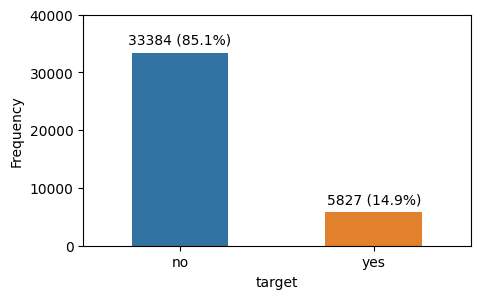

In [11]:
plt.figure(figsize=(5,3))
plt.yticks(ticks=range(0, 40001, 10000))
ax=sns.countplot(x=train['target'], data=train, width=0.5)
ax.set_ylabel('Frequency')
ax.set_ylim(0, 40001)

total = len(train)
for p in ax.patches:
    height = p.get_height()
    percentage = (height / total) * 100
    ax.annotate(f'{height:.0f} ({percentage:.1f}%)',(p.get_x() + p.get_width() / 2., height + 1000),
                ha='center', va='bottom');


* The dataset is highly imbalanced. 85% of the data has target=no.

## **Univariate Analysis**

**Age (Numerical)**

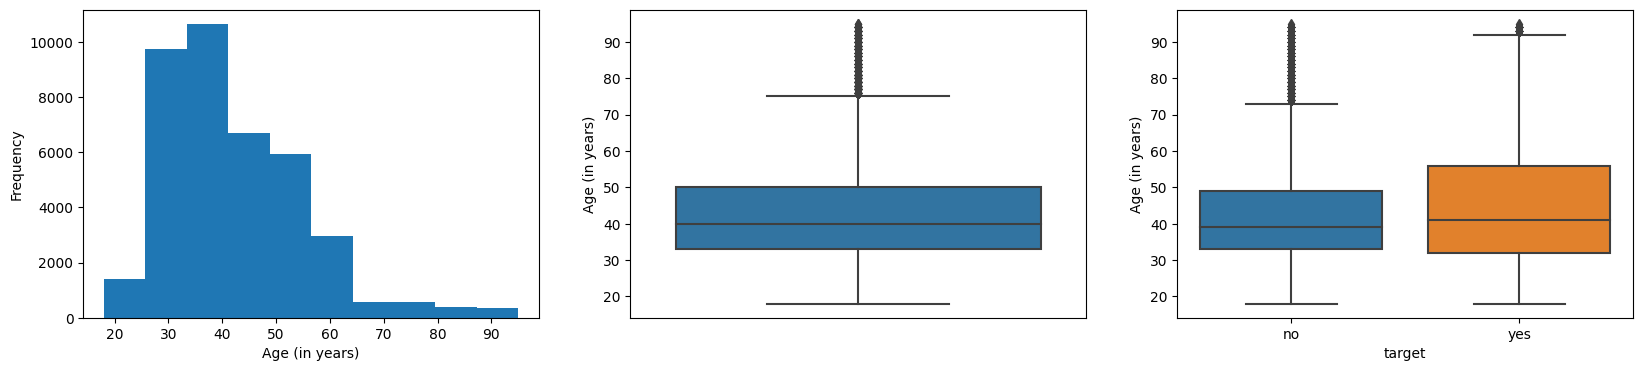

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(20, 4))

# Histogram
axes[0].hist(train['age'])
axes[0].set_xlabel('Age (in years)')
axes[0].set_ylabel('Frequency')

# Boxplot
sns.boxplot(train['age'], ax=axes[1])
axes[1].set_xticks([])
axes[1].set_ylabel('Age (in years)')

# Grouped boxplot, target-wise
sns.boxplot(train, x=train['target'],y=train['age'],ax=axes[2])
axes[2].set_ylabel('Age (in years)')

plt.show()

* Most samples have age in 30-40 range.
* Outliers lie in 75-90+ range, which are also acceptable values.
* Median of target=no and target=yes both lie around 40. Age may not be impacting the target much.

**Balance (Numerical)** 

In [13]:
# Basic descriptive statistics
desc = train['balance'].describe()

# Getting 90th, 95th and 99th percentiles
desc['90%'] = train['balance'].quantile(0.90)
desc['95%'] = train['balance'].quantile(0.95)
desc['99%'] = train['balance'].quantile(0.99)

print(desc)

count     39211.000000
mean       5441.781719
std       16365.292065
min       -8019.000000
25%          98.000000
50%         549.000000
75%        2030.000000
max      102127.000000
90%        8121.000000
95%       40126.500000
99%       90037.500000
Name: balance, dtype: float64


* Huge difference between 75% and max values, but the values are increasing steadily. 95%, 99% and max values are close enough. Need not consider as outliers.

**Duration (Numerical)**

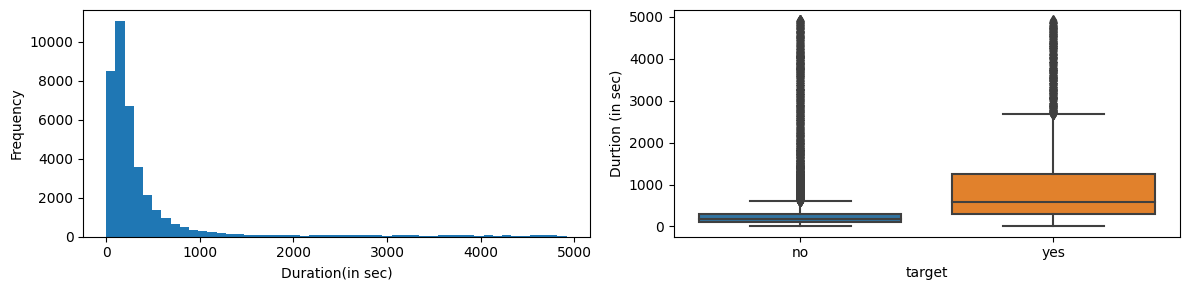

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(12, 3))

# Histogram
axes[0].hist(train['duration'],bins=50)
axes[0].set_xlabel('Duration(in sec)')
axes[0].set_ylabel('Frequency')

# Grouped boxplot, target-wise
sns.boxplot(train, x=train['target'],y=train['duration'],ax=axes[1])
axes[1].set_ylabel('Durtion (in sec)')

plt.tight_layout()
plt.show()

* Duration is highly skewed showing power-law distribution.
* For target=no, mean duration is lesser. For target=yes, mean duration is higher. Customers collecting more information over the call =>  more likely to subscribe to the term deposit.
* High chances that duration will affect the target variable.

**Job (Categorical - Nominal)**

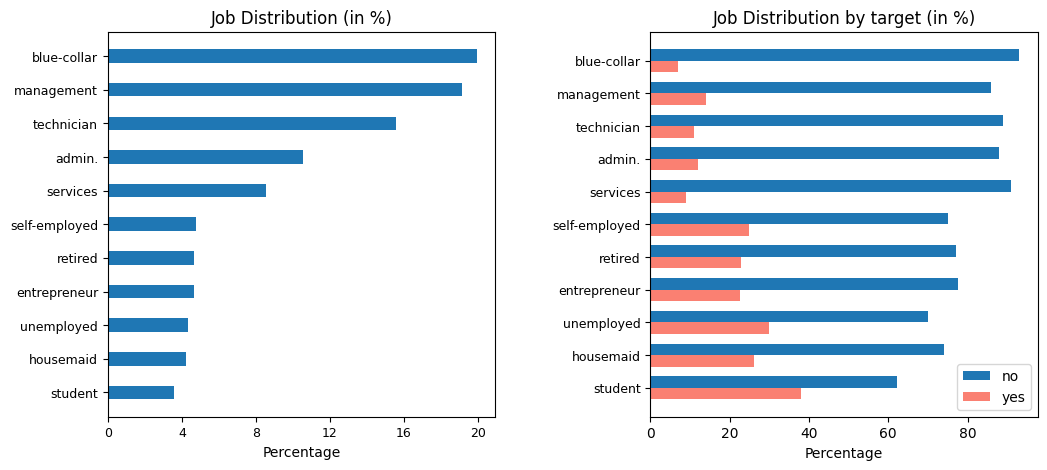

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Creating a horizontal bar plot to accommodate job titles better
job_counts = (train['job'].value_counts(normalize=True) * 100).sort_values(ascending=True)
axes[0].barh(job_counts.index, job_counts.values,height=0.4)
axes[0].tick_params(axis='both', which='major', labelsize=9)
axes[0].set_title('Job Distribution (in %)')
x_ticks = np.arange(0, max(job_counts.values) + 3,4)  # Create ticks from 0 to max value
axes[0].set_xticks(x_ticks)
axes[0].set_xticklabels(x_ticks.astype(int), fontsize=9)
axes[0].set_xlabel('Percentage')

plt.subplots_adjust(wspace=0.4)

# Grouped bar plot, target-wise
counts = train.pivot_table(index='job', columns=train['target'], aggfunc='size', fill_value=0)
counts_percent = counts.div(counts.sum(axis=1), axis=0) * 100
counts_percent = counts_percent.reindex(job_counts.index)
y_axis = np.arange(len(counts_percent.index))  # positions for job types
width = 0.35 

# Create the bars for targets
axes[1].barh(y_axis + width/2, counts_percent['no'], width, label='no')
axes[1].barh(y_axis - width/2, counts_percent['yes'], width, label='yes', color='salmon')

# Set the labels and title
axes[1].set_yticks(y_axis)
axes[1].set_yticklabels(counts_percent.index,fontsize=9)
axes[1].set_title('Job Distribution by target (in %)')
axes[1].set_xlabel('Percentage')

axes[1].legend()
plt.show()

* 'blue-collar' category has highest overall frequency, but least subscription rate.
* 'student' category has lowest overall frequency, but highest subscription rate.

**Other Categorical Features**

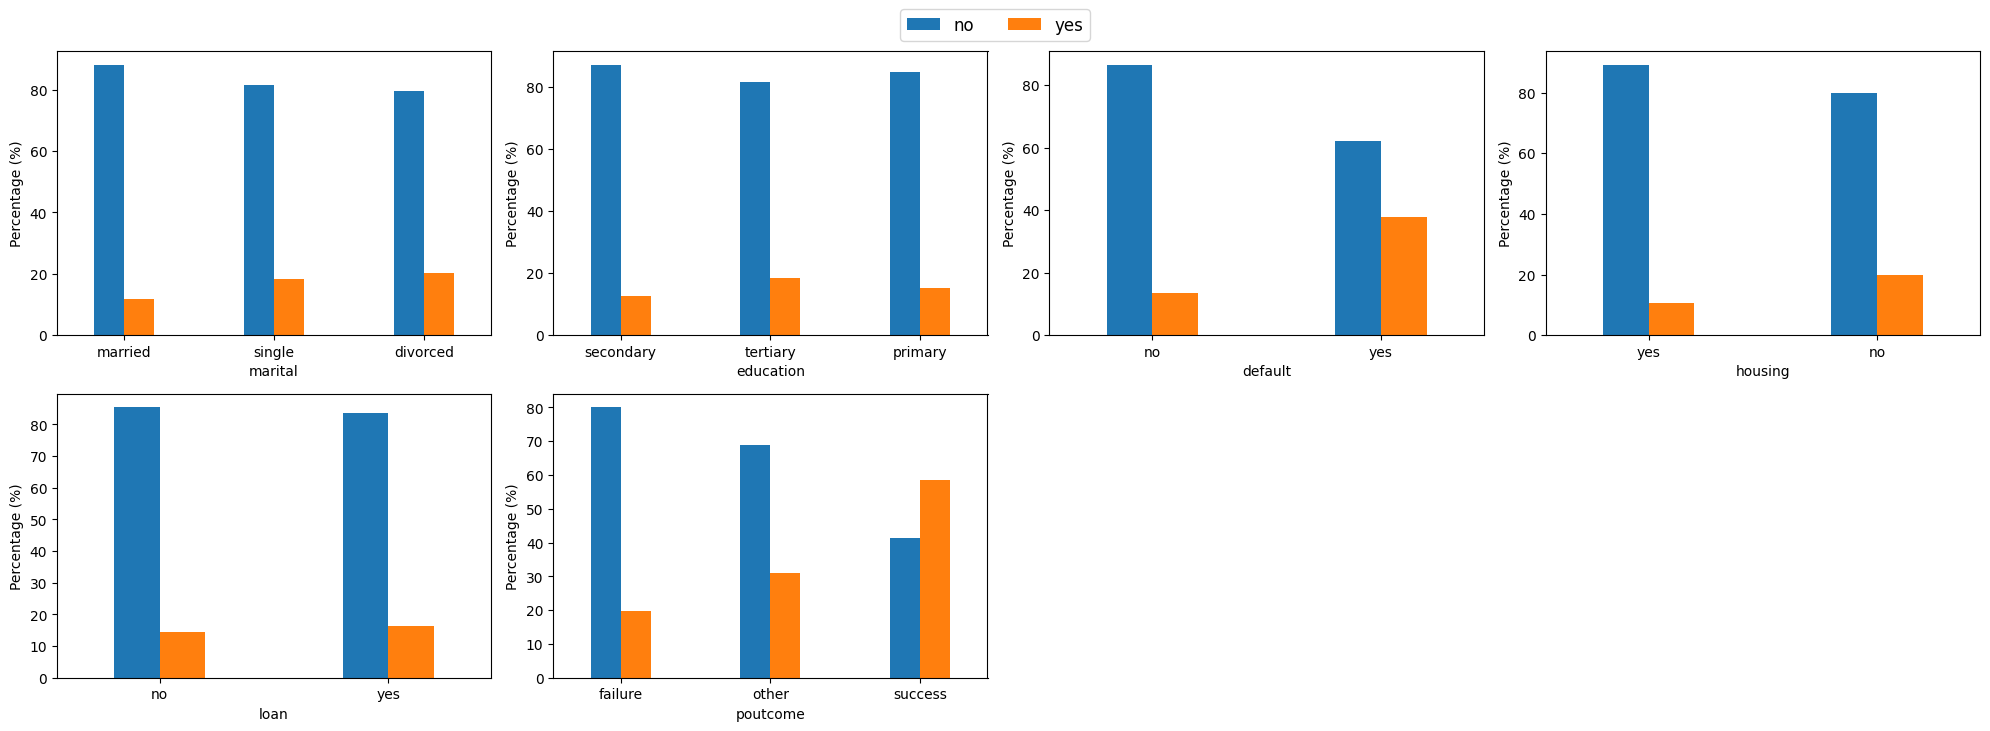

In [16]:
cols = ['marital','education','default','housing','loan','poutcome']

num_plots = len(cols)
fig, axes = plt.subplots(math.ceil(num_plots /4), 4, figsize=(20,7))
axes = axes.flatten()
i=0             # To track subplot numbers

for col in cols:
    counts = train.pivot_table(index=col, columns=train['target'], aggfunc='size', fill_value=0)
    counts_percent = counts.div(counts.sum(axis=1), axis=0) * 100
    counts_percent = counts_percent.reindex(train[col].value_counts().index)
    counts_percent.plot(kind='bar', stacked=False,ax=axes[i],width=0.4,legend=False,rot=0)
    axes[i].set_ylabel('Percentage (%)')
        
    i+=1

# Create a single legend for all subplots

handles, labels = axes[0].get_legend_handles_labels()  # Get the handles and labels from the first subplot
fig.legend( handles, labels, loc='upper center', ncol=2, bbox_to_anchor=(0.5, 1.05), fontsize='large')

# Hide any remaining unused axes
for j in range(num_plots, len(axes)):
    axes[j].axis('off')

    
plt.tight_layout()
plt.show();

Observations:
* Single/divorced customers are more likely to subscribe than 'married' customers.
* Outstanding credit default => High chances of subscription. (**Counter-intuitive!**)
* No active housing loan => High chances of subscription.
* Education and personal loan status have lesser impact on the target.
* poutcome = success => High chances of target=Yes. poutcome can be an important feature. Cannot drop it. Need better techniques to impute.

**Contact month and date**

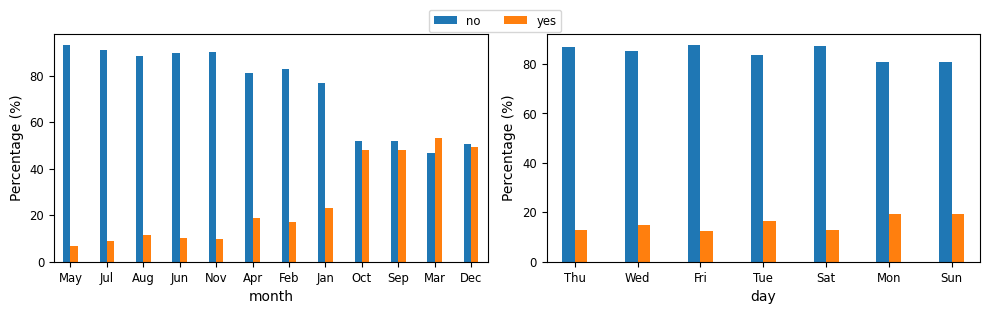

In [17]:
cols = ['month','day']

num_plots = len(cols)
fig, axes = plt.subplots(1,2, figsize=(10,3))
axes = axes.flatten()
i=0             # To track subplot numbers

for col in cols:
    counts = train.pivot_table(index=col, columns=train['target'], aggfunc='size', fill_value=0)
    counts_percent = counts.div(counts.sum(axis=1), axis=0) * 100
    counts_percent = counts_percent.reindex(train[col].value_counts().index)
    counts_percent.plot(kind='bar', stacked=False,fontsize='small',ax=axes[i],width=0.4,legend=False,rot=0)
    axes[i].set_ylabel('Percentage (%)')
    i+=1

# Create a single legend for all subplots

handles, labels = axes[0].get_legend_handles_labels()  # Get the handles and labels from the first subplot
fig.legend( handles, labels, loc='upper center', ncol=2, bbox_to_anchor=(0.5, 1.05), fontsize='small')

# Hide any remaining unused axes
for j in range(num_plots, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show();

* Customers contacted in March have higher subscription rates, followed by Oct, Sep and Dec.
* Weekday of contact has no big impact on target.

**Correlation among age - balance - duration**

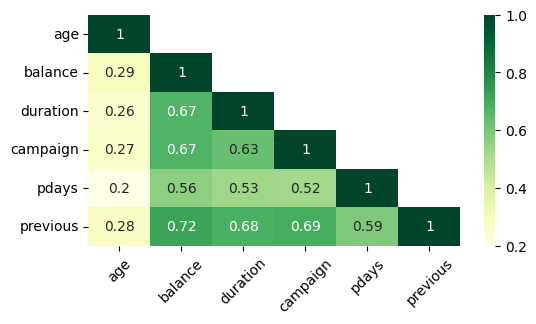

In [18]:
plt.figure(figsize=(6, 3))
corr = train[train.select_dtypes(exclude='object').columns].corr()
mask = np.triu(np.ones_like(corr, dtype=bool),k=1)
sns.heatmap(corr,annot=True,cmap='YlGn',mask=mask)
plt.xticks(rotation=45)
plt.show()

Observations:
* Age is least correlated with any other numerical feature.
* 'balance' has moderate amount of correlation with duraion of call. More balance => interested to take up fixed deposit => Collect more details over call.
* 'balance' also has good correlation with 'previous'. More balance (targetted customer) => more marketing calls from bank. 

# **Data Preprocessing**

In [19]:
# Separating out features and target variable from input data

X = train.drop(['target'],axis=1)
y = train['target'].map({'no':0,'yes':1})

In [20]:
# Splitting the dataset into training and validation sets

X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                    test_size = 0.2,
                                                    random_state=42,
                                                     stratify = y)    # To ensure the same proportion of classes in both sets

In [21]:
print('Training dataset shape :',X_train.shape)
print('Validation dataset shape :',X_val.shape)

Training dataset shape : (31368, 16)
Validation dataset shape : (7843, 16)


In [22]:
# Segregating numerical and categorical column names

num_cols = X_train.select_dtypes(exclude = ['object']).columns
cat_cols = X_train.select_dtypes(include = ['object']).columns

In [23]:
# Numerical pipeline for imputation & scaling of numerical columns
num_pipe = Pipeline([
                        ('scaler', StandardScaler())
                    ])

# Categorical pipeline for imputation & encoding of categorical columns

cat_pipe = Pipeline([
                        ('imputer', SimpleImputer(strategy = 'constant',fill_value='Missing')),
                        ('encoder',OneHotEncoder(sparse_output=False,handle_unknown = 'ignore'))
                    ])

# ColumnTransformer to apply the above pipelines
preprocessor = ColumnTransformer([
                                    ('numerical', num_pipe, num_cols),
                                    ('categorical', cat_pipe, cat_cols)
                                ])

Iterative Imputer captures complex relationships between features. This approach led to an increase in model's F1-score, demonstrating its effectiveness over SimpleImputer.

In [24]:
X_train = pd.DataFrame(preprocessor.fit_transform(X_train))

X_val = pd.DataFrame(preprocessor.transform(X_val))
X_test = pd.DataFrame(preprocessor.transform(X_test))

All the data is now preprocessed where numerical columns are imputed + scaled and categorical columns are encoded + imputed.

# **Feature Engineering**

In [25]:
X_train.shape

(31368, 57)

In [26]:
#from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif, f_classif

# selector = SelectKBest(mutual_info_classif, 
#                        k=47)

# X_train_selected = selector.fit_transform(X_train,y_train)
# X_val_selected = selector.transform(X_val)
# X_test_selected = selector.transform(X_test)

# X_train_selected = pd.DataFrame(X_train_selected, columns = X_train.columns[selector.get_support()])
# X_val_selected = pd.DataFrame(X_val_selected, columns = X_train.columns[selector.get_support()])
# X_test_selected = pd.DataFrame(X_test_selected, columns = X_train.columns[selector.get_support()])

SelectKBest does not have random_state parameter. Could not ensure reproducibility of the feature selection.

In [27]:
# selector = SelectFromModel(RandomForestClassifier(random_state=42), threshold='mean')

# selector = SelectFromModel(Lasso(alpha=0.01))

# selector = RFE(SGDClassifier(class_weight='balanced',
#                            learning_rate='adaptive',
#                            eta0=0.1,
#                            random_state=42),
#               n_features_to_select = 30)

Tried 3 different models (RandomForest, Lasso and SGD) for feature selection. But the validation scores obtained were below 0.757.

In [28]:
selector = SelectFromModel(XGBClassifier(random_state=42))

X_train_selected = selector.fit_transform(X_train,y_train)
X_val_selected = selector.transform(X_val)
X_test_selected = selector.transform(X_test)

X_train_selected = pd.DataFrame(X_train_selected, columns = X_train.columns[selector.get_support()])
X_val_selected = pd.DataFrame(X_val_selected, columns = X_train.columns[selector.get_support()])
X_test_selected = pd.DataFrame(X_test_selected, columns = X_train.columns[selector.get_support()])

SelectFromModel with XGBClassifier(random_state=42) allows for automatic feature selection based on feature importance scores derived from the model. This approach increased f1-scores upto 0.76

# **Modeling**

In this section, six different machine learning algorithms are being evaluated.
* Logistic Regression
* Stochastic Gradient Descent (SGD) Classifier
* Decision Tree Classifier
* Random Forest Classifier
* Gradient Boosting Classifier and 
* XGBoost Classifier. 

Each model offers unique advantages: 
* Logistic Regression provides simple and easy interpretability while being fast.
* SGD is efficient for large datasets. It also accepts L1 and L2 regularization.
* Decision Trees can model non-linear relationships between features.
* Random Forest improves accuracy through ensemble learning.
* Gradient Boosting and XGBoost enhance predictive performance by iteratively correcting errors in previous models. 

By testing these models sequentially, we aim to identify the best performer for prediction.

In [29]:
# Function to fit a model on training set

def fit_model(model,X_train, X_val, y_train, y_val):
    
    fitted_model = model.fit(X_train, y_train)
    
    y_train_pred = fitted_model.predict(X_train)
    y_val_pred = fitted_model.predict(X_val)
    
    train_score = f1_score(y_train, y_train_pred,average='macro')
    val_score = f1_score(y_val, y_val_pred,average='macro')
    
    return (fitted_model,train_score,val_score)

In [30]:
# Funtion to tune a model on a parameter grid

def fit_hpt_model(model,param_grid,X_train, X_val, y_train, y_val):
    
    f1_scorer = make_scorer(f1_score, average='macro')

    grid_search_cv = GridSearchCV(model,
                                 param_grid,
                                 scoring=f1_scorer,
                                 n_jobs=-1)
    grid_search_cv.fit(X_train,y_train)
    
    print("Best parameters:", grid_search_cv.best_params_)
    
    y_train_pred = grid_search_cv.best_estimator_.predict(X_train)
    y_val_pred = grid_search_cv.best_estimator_.predict(X_val)
    
    train_score = f1_score(y_train, y_train_pred,average='macro')
    val_score = f1_score(y_val, y_val_pred,average='macro')
    
    print('Training F1-score ', train_score)
    print('Validation F1-score ', val_score)
    
    return (grid_search_cv.best_estimator_,train_score,val_score)

In [31]:
# Dataframe to collect validation scores of various models

scores_summary = pd.DataFrame(columns=["Model", "Validation F1 score"])

In [32]:
dummy_model = DummyClassifier(strategy='uniform',random_state=42)

(dummy_model,train_score,val_score) = fit_model(dummy_model,X_train, X_val, y_train, y_val)

print('Training F1-score ', train_score)
print('Validation F1-score ', val_score)

scores_summary.loc[len(scores_summary)] = ["Dummy",val_score]

Training F1-score  0.4249594834481936
Validation F1-score  0.4396838159112511


## **Logistic Regression**

In [33]:
logistic = LogisticRegression(max_iter=1000,
                            random_state=42)

(logistic_model,train_score,val_score) = fit_model(logistic,X_train_selected, X_val_selected, y_train, y_val)

print('Training F1-score ', train_score)
print('Validation F1-score ', val_score)

Training F1-score  0.6125708156598898
Validation F1-score  0.6269785566480315


In [34]:
# Hyper parameter tuning for regularization term

param_grid ={'C': [0.0001, 0.001, 0.01, 0.1, 1],
            'class_weight' : [None,'balanced'],
            'solver':['lbfgs','saga']}

(logistic_hpt_model,train_score,val_score) = fit_hpt_model(logistic, param_grid, 
                                                           X_train_selected, X_val_selected, y_train, y_val)

scores_summary.loc[len(scores_summary)] = ["Logistic",val_score]

Best parameters: {'C': 1, 'class_weight': 'balanced', 'solver': 'lbfgs'}
Training F1-score  0.7418421498102146
Validation F1-score  0.7467274427302478


* With hyper-parameter tuning, f1-score improved by 19%.
* Could not reach minimum required value of 0.75.

## **SGD Classifier**

In [35]:
sgd  = SGDClassifier(class_weight='balanced',
                    random_state=42)

(sgd_model,train_score,val_score) = fit_model(sgd,X_train_selected, X_val_selected, y_train, y_val)

print('Training F1-score ', train_score)
print('Validation F1-score ', val_score)

Training F1-score  0.7522817321390891
Validation F1-score  0.7523803729969861


In [36]:
# Hyper parameter tuning for regularization term

param_grid = {
                'alpha': [0.0001, 0.001, 0.01, 0.1],
                'learning_rate' : ['constant','adaptive'],
                'eta0':[0.01,0.1],
                'loss': ['hinge','log_loss','perceptron'],
                'penalty': ['l2','l1','elasticnet']
            }

(sgd_hpt_model,train_score,val_score) = fit_hpt_model(sgd, param_grid,
                                                      X_train_selected, X_val_selected, y_train, y_val)

scores_summary.loc[len(scores_summary)] = ["SGD",val_score]

Best parameters: {'alpha': 0.001, 'eta0': 0.01, 'learning_rate': 'adaptive', 'loss': 'hinge', 'penalty': 'elasticnet'}
Training F1-score  0.7560012651284251
Validation F1-score  0.7605599164232768


* f1-score on full dataset : 0.74.
* f1-score on selected features : 0.75
* f1-score with Hyper parameter tuning : 0.76
* SGD classifier is exhibiting its flexibility in optimizing various loss functions, leading to better generalization.

## **Decision Tree Classifier**

In [37]:
dt = DecisionTreeClassifier(random_state=42)

(dt_model,train_score,val_score) = fit_model(dt, X_train, X_val, y_train, y_val)

print('Training F1-score ', train_score)
print('Validation F1-score ', val_score)

Training F1-score  1.0
Validation F1-score  0.687502967068893


* Default parameter settings of Decision Tree Classifier are overfitting. Necessary to tune.

In [38]:
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [ 2, 5, 10],  
    'min_samples_split': [2, 5, 10],              
    'min_samples_leaf': [1, 2, 5, 10],            
    'max_features': [None, 'sqrt', 'log2']        
}

(dt_hpt_model,train_score,val_score) = fit_hpt_model(dt, param_grid,
                                                      X_train, X_val, y_train, y_val)

scores_summary.loc[len(scores_summary)] = ["Decision Tree",val_score]

Best parameters: {'criterion': 'gini', 'max_depth': 2, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Training F1-score  0.7359177824031062
Validation F1-score  0.7442645481362296


* The above best parameters could control the overfitting efficiently.
* But, low value of Validation f1-score.
* Need to check ensemble methods that combines the predictions of multiple decision trees to enhance overall performance.

## **Random Forest Classifier**

In [39]:
rfc = RandomForestClassifier(random_state=42,
                             class_weight = 'balanced',
                             n_jobs=-1)

(rfc_model,train_score,val_score) = fit_model(rfc, X_train, X_val, y_train, y_val)

print('Training F1-score ', train_score)
print('Validation F1-score ', val_score)

Training F1-score  1.0
Validation F1-score  0.6945274379504003


* Default parameter settings are overfitting.

In [40]:
# param_grid = {
#     'n_estimators': [1000, 2000],            
#     'max_depth': [ 5, 10, 15],                          
#     'min_samples_split': [10, 15, 20],               
#     'min_samples_leaf': [1, 2, 3], 
# }

# (rfc_hpt_model,train_score,val_score) = fit_hpt_model(rfc, param_grid,
#                                                       X_train, X_val, y_train, y_val)

rfc = RandomForestClassifier(random_state=42,
                             n_estimators = 1000,
                             max_depth=15,
                             min_samples_split = 15,
                             min_samples_leaf = 3,
                             class_weight = 'balanced',
                             n_jobs=-1)

(rfc_model,train_score,val_score) = fit_model(rfc,X_train, X_val, y_train, y_val)

print('Training F1-score ', train_score)
print('Validation F1-score ', val_score)

scores_summary.loc[len(scores_summary)] = ["Random Forest",val_score]

Training F1-score  0.7997983188703427
Validation F1-score  0.7638113736087166


* Satisfactory validation score by Random Forest.
* Further exploring Gradient Boosting and XGBoost for any additional improvements. These models have the potential to refine predictions by focusing on correcting errors.

## **Gradient Boosting Classifier**

In [41]:
gbm = GradientBoostingClassifier(n_estimators=300,
                                 random_state=42)

(gbm_model,train_score,val_score) = fit_model(gbm, X_train, X_val, y_train, y_val)

print('Training F1-score ', train_score)
print('Validation F1-score ', val_score)

scores_summary.loc[len(scores_summary)] = ["Gradient Boost",val_score]

Training F1-score  0.7860095989587629
Validation F1-score  0.7344317328217538


In [42]:
# param_grid = {
#     'n_estimators': [100, 200, 300],
#     'learning_rate': [0.01, 0.1, 0.05],
#     'max_depth': [2, 3, 5],
#     'subsample': [0.8, 1.0]  # Subsampling to reduce overfitting
# }

# (gbm_hpt_model,train_score,val_score) = fit_hpt_model(gbm, param_grid,
#                                                       X_train, X_val, y_train, y_val)

* Default parameter values are giving better score than hyper tuned parameters for Gradient Boost Classifier.
* But Gradient Boosting does not exhibit good generalization in our dataset.

## **XG Boost Classifier**

In [43]:
# from sklearn.model_selection import RandomizedSearchCV

# xgb = XGBClassifier(random_state=42)

# param_dist = {
#     'learning_rate': [0.005, 0.01, 0.1],
#     'n_estimators': [500, 1000, 2000],
#     'max_depth': [3, 4, 5, 6, 7],
#     'min_child_weight': [1, 3, 5, 7, 9],
#     'subsample': [0.6, 0.7, 0.8, 0.9],
#     'colsample_bytree': [0.6, 0.7, 0.8, 0.9],
#     'gamma': [0, 0.1, 0.3, 0.5],
#     'reg_lambda': [0, 1, 2, 3],
#     'reg_alpha': [0, 0.5, 1, 1.5],
#     'scale_pos_weight': [1, 2, 3]  
# }

# random_search = RandomizedSearchCV(
#                                     xgb,
#                                     param_distributions=param_dist,
#                                     n_iter=100, 
#                                     scoring=make_scorer(f1_score,average='macro'),
#                                     cv=5, 
#                                     verbose=2,
#                                     n_jobs=-1,
#                                     random_state=42
#                                 )

# random_search.fit(X_train, y_train)

# print("Best Parameters:", random_search.best_params_)
# print("Best F1 Score:", random_search.best_score_)

# best_model = random_search.best_estimator_
# y_pred = best_model.predict(X_val)

# f1 = f1_score(y_val, y_pred)
# print("Validation F1 Score:", f1)

In [44]:
xgb = XGBClassifier(
                    random_state=42,
                    learning_rate=0.005,
                    n_estimators=2300,
                    max_depth=5,              
                    min_child_weight=9,      
                    subsample=0.8,
                    colsample_bytree=0.7,
                    gamma=0.3,
                    reg_lambda=1.5,
                    reg_alpha=0.7,
                    scale_pos_weight=2.75,
                    n_jobs=-1
                )

(xgb_model, train_score, val_score) = fit_model(xgb,X_train, X_val, y_train, y_val)

print('Training F1-score ', train_score)
print('Validation F1-score ', val_score)

scores_summary.loc[len(scores_summary)] = ["XGBoost",val_score]

Training F1-score  0.7894958234198275
Validation F1-score  0.776724170222512


* XGBoost exhibits strong F1-score on the training set, indicating good performance in balancing precision and recall.
* Validation F1-score of 0.776. Minor overfitting but good consistency.

# **Model Evaluation**

Multiple models were evaluated to predict the success of bank telemarketing campaigns, with the F1-score being the primary metric for performance assessment.  Below is the score comparision across the models.

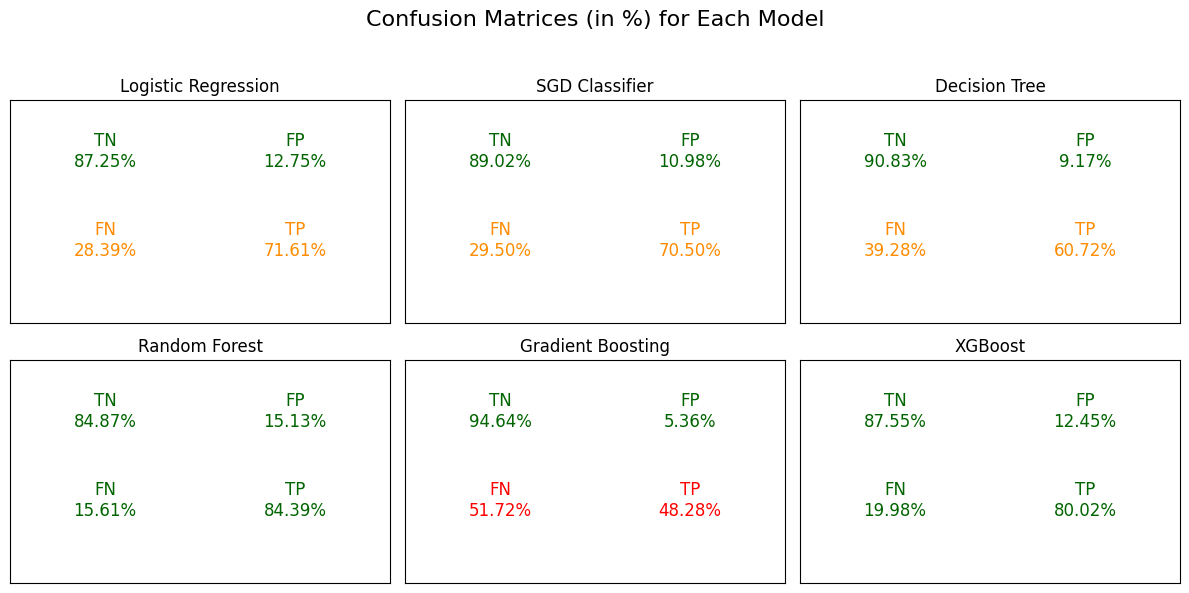

In [45]:
# Predictions for each model
y_pred_logistic = logistic_hpt_model.predict(X_val_selected)
y_pred_sgd = sgd_hpt_model.predict(X_val_selected)
y_pred_dt = dt_hpt_model.predict(X_val)
y_pred_rfc = rfc_model.predict(X_val)
y_pred_gbm = gbm_model.predict(X_val)
y_pred_xgb = xgb_model.predict(X_val)

# Define titles and predictions for each model
models = [
    ("Logistic Regression", y_pred_logistic),
    ("SGD Classifier", y_pred_sgd),
    ("Decision Tree", y_pred_dt),
    ("Random Forest", y_pred_rfc),
    ("Gradient Boosting", y_pred_gbm),
    ("XGBoost", y_pred_xgb),
]

# Function to set text color based on the desired logic
def get_text_color(value, is_tn_or_tp):
    if is_tn_or_tp:
        # Green for TN and TP, as high is better
        if value > 80:
            return "darkgreen"
        elif value > 50:
            return "darkorange"
        else:
            return "red"
    else:
        # Green for FN and FP, as low is better (inverse logic)
        if value < 20:
            return "darkgreen"
        elif value < 50:
            return "darkorange"
        else:
            return "red"

# Set up the figure with compact size
fig, axes = plt.subplots(2, 3, figsize=(12, 6))
fig.suptitle("Confusion Matrices (in %) for Each Model", fontsize=16)

# Flatten axes for easy iteration
axes = axes.flatten()

# Plot each confusion matrix in a compact format
for i, (title, y_pred) in enumerate(models):
    # Compute confusion matrix and normalize to get percentages
    cm = confusion_matrix(y_val, y_pred, normalize='true') * 100
    
    # Extract values for easy display
    tn, fp, fn, tp = cm.ravel()
    
    # Display the confusion matrix with label and value on separate lines
    axes[i].text(0.5, 0.7, f"TN\n{tn:.2f}%", ha='center', fontsize=12, color=get_text_color(tn, True))
    axes[i].text(1.5, 0.7, f"FP\n{fp:.2f}%", ha='center', fontsize=12, color=get_text_color(fp, False))
    axes[i].text(0.5, 0.3, f"FN\n{fn:.2f}%", ha='center', fontsize=12, color=get_text_color(fn, False))
    axes[i].text(1.5, 0.3, f"TP\n{tp:.2f}%", ha='center', fontsize=12, color=get_text_color(tp, True))
    
    # Formatting for each subplot
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    axes[i].set_xlim(0, 2)
    axes[i].set_ylim(0, 1)
    axes[i].set_title(title)
    axes[i].plot([], [])  # Hide default box and grid

# Remove empty spaces and display the compact confusion matrices
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


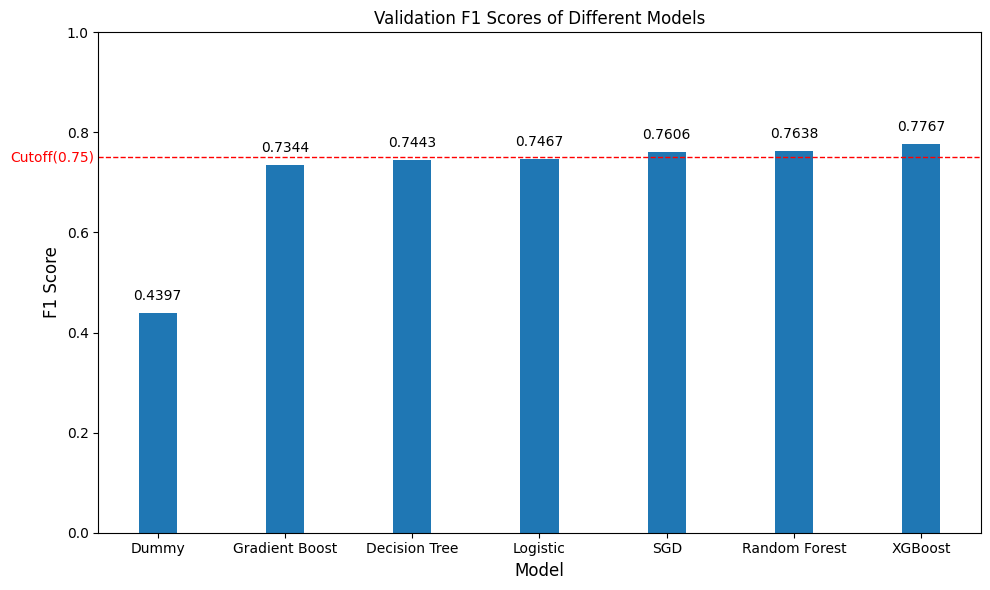

In [46]:
scores_summary.sort_values(by="Validation F1 score", inplace=True)

# Plotting
plt.figure(figsize=(10, 6))
bars = plt.bar(scores_summary["Model"], scores_summary["Validation F1 score"],width=0.3)
plt.xlabel('Model',fontsize=12)
plt.ylabel('F1 Score',fontsize=12)
plt.title('Validation F1 Scores of Different Models')
plt.ylim(0, 1)

# Add annotations on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.02, round(yval, 4), 
             ha='center', va='bottom', fontsize=10, )

plt.axhline(y=0.75, color='red', linestyle='--', linewidth=1)
plt.text(-0.5, 0.75, 'Cutoff(0.75)', color='red', va='center', ha='right', fontsize=10)
plt.tight_layout()
plt.show()

* Dummy classifier served as a baseline, with validation F1-score of 0.439. 
* Among the models tested, XGBoost performed the best with a score of 0.776, demonstrating its superior ability to handle the complexities of the dataset. 
* Random Forest and Stochastic Gradient Descent (SGD) also performed well.
* Logistic regression and Decision Tree models achieved comparable scores around 0.745, while Gradient Boost had a slightly lower F1-score of 0.734. 

**Overall, XGBoost stood out as the most effective model for this task.**

# **Final Prediction and Conclusion**

After comparing various models, XGBoost proved to be the most accurate and reliable for this prediction task. The model's robustness and consistency across both training and validation datasets make it a strong choice for deployment in real-world applications. However, further tuning and validation on unseen data may further enhance performance.

In [47]:
y_test = xgb_model.predict(X_test)

In [48]:
submission = pd.DataFrame(columns=['id','target'])
submission['id'] = [i for i in range(len(y_test))]
submission['target'] = pd.Series(y_test).map({0:'no',1:'yes'})
submission.to_csv('submission.csv',index=False)